In [1]:
path='/content/drive/' # Use this cell if using colab
from google.colab import drive
drive.mount(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
#change path accordingly
%cd drive/MyDrive/Hacktober2k22/"Flight Price Prediction"

/content/drive/MyDrive/Hacktober2k22/Flight Price Prediction


In [3]:
!ls

 Dataset  'flight price.ipynb'	 flight_rf.pkl	 README.md


# **Exploratory Data Analysis**

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import pickle

In [5]:
train_data = pd.read_excel('Dataset/Data_Train.xlsx')
train_data.head()
train_data['Destination'].value_counts()

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [6]:
def newd(x):
    if x=='New Delhi':
        return 'Delhi'
    else:
        return x
train_data['Destination'] = train_data['Destination'].apply(newd)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [8]:
train_data['Journey_day'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.day
train_data['Journey_month'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.month
train_data.drop('Date_of_Journey',inplace=True,axis=1)
train_data.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,Banglore,Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [9]:
train_data['Dep_hour'] = pd.to_datetime(train_data['Dep_Time']).dt.hour
train_data['Dep_min'] = pd.to_datetime(train_data['Dep_Time']).dt.minute
train_data.drop('Dep_Time',axis=1,inplace=True)
train_data['Arrival_hour'] = pd.to_datetime(train_data['Arrival_Time']).dt.hour
train_data['Arrival_min'] = pd.to_datetime(train_data['Arrival_Time']).dt.minute
train_data.drop('Arrival_Time',axis=1,inplace=True)
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [10]:
train_data['Duration'].value_counts()

2h 50m     550
1h 30m     386
2h 45m     337
2h 55m     337
2h 35m     329
          ... 
31h 30m      1
30h 25m      1
42h 5m       1
4h 10m       1
47h 40m      1
Name: Duration, Length: 368, dtype: int64

In [11]:
duration = list(train_data['Duration'])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if 'h' in duration[i]:
            duration[i] = duration[i] + ' 0m'
        else:
            duration[i] = '0h ' + duration[i]

duration_hour = []
duration_min = []

for i in duration:
    h,m = i.split()
    duration_hour.append(int(h[:-1]))
    duration_min.append(int(m[:-1]))

train_data['Duration_hours'] = duration_hour
train_data['Duration_mins'] = duration_min

train_data.drop('Duration',axis=1,inplace=True)
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


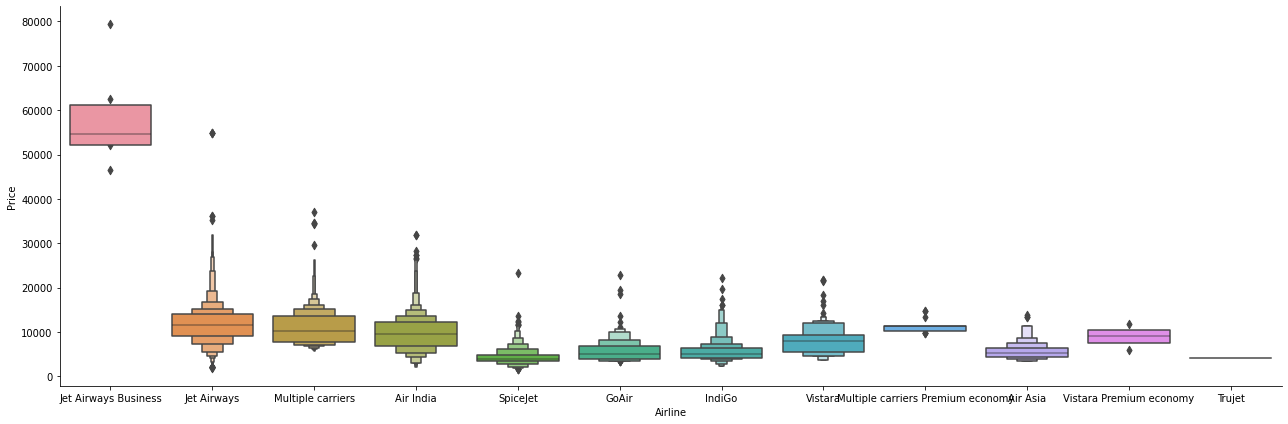

In [12]:
sns.catplot(x='Airline',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=6)

In [13]:
airline = train_data[['Airline']]
airline = pd.get_dummies(airline,drop_first=True)

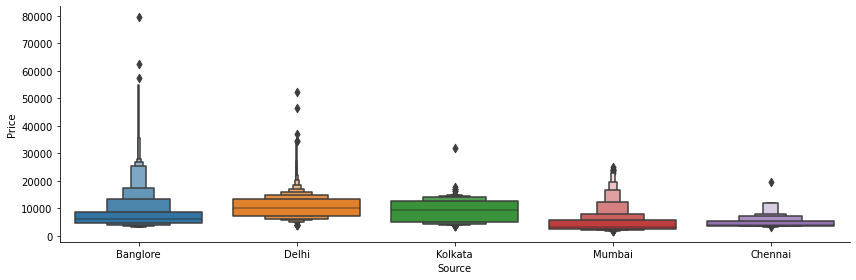

In [14]:
# If we are going from Banglore the prices are slightly higher as compared to other cities
sns.catplot(x='Source',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

In [15]:
source = train_data[['Source']]
source = pd.get_dummies(source,drop_first=True)
source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


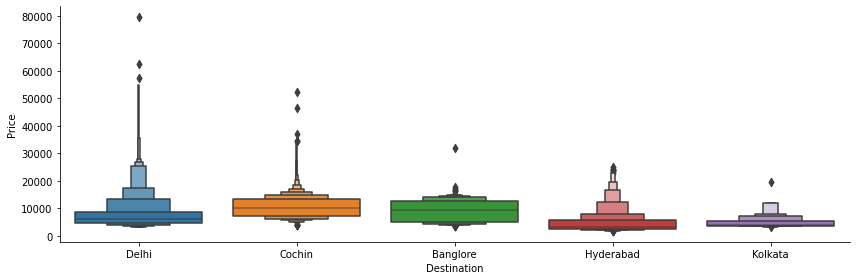

In [16]:
# If we are going to New Delhi the prices are slightly higher as compared to other cities
sns.catplot(x='Destination',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

In [17]:
destination = train_data[['Destination']]
destination = pd.get_dummies(destination,drop_first=True)
destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,1,0,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,1,0,0


In [18]:
train_data.drop(['Route','Additional_Info'],inplace=True,axis=1)

In [19]:
train_data['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [20]:
# acc to the data, price is directly prop to the no. of stops
train_data['Total_Stops'].replace({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4},inplace=True)
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,0.0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2.0,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2.0,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1.0,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1.0,13302,1,3,16,50,21,35,4,45


In [21]:
print(airline.shape)
print(source.shape)
print(destination.shape)
print(train_data.shape)

(10683, 11)
(10683, 4)
(10683, 4)
(10683, 13)


In [22]:
data_train = pd.concat([train_data,airline,source,destination],axis=1)
data_train=data_train.dropna()
data_train.drop(['Airline','Source','Destination'],axis=1,inplace=True)
data_train.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0.0,3897,24,3,22,20,1,10,2,50,...,0,0,0,0,0,0,0,1,0,0
1,2.0,7662,1,5,5,50,13,15,7,25,...,0,0,0,0,1,0,0,0,0,0
2,2.0,13882,9,6,9,25,4,25,19,0,...,0,0,0,1,0,0,1,0,0,0
3,1.0,6218,12,5,18,5,23,30,5,25,...,0,0,0,0,1,0,0,0,0,0
4,1.0,13302,1,3,16,50,21,35,4,45,...,0,0,0,0,0,0,0,1,0,0


In [23]:
X = data_train.drop('Price',axis=1)
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0.0,24,3,22,20,1,10,2,50,0,...,0,0,0,0,0,0,0,1,0,0
1,2.0,1,5,5,50,13,15,7,25,1,...,0,0,0,0,1,0,0,0,0,0
2,2.0,9,6,9,25,4,25,19,0,0,...,0,0,0,1,0,0,1,0,0,0
3,1.0,12,5,18,5,23,30,5,25,0,...,0,0,0,0,1,0,0,0,0,0
4,1.0,1,3,16,50,21,35,4,45,0,...,0,0,0,0,0,0,0,1,0,0


In [24]:
y = data_train['Price']
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

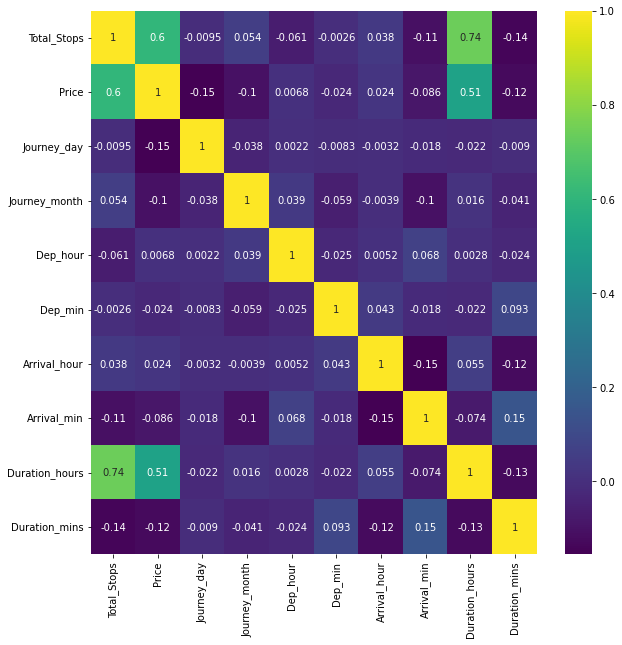

In [25]:
plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(),cmap='viridis',annot=True)

In [26]:
reg = ExtraTreesRegressor()
reg.fit(X,y)

print(reg.feature_importances_)

[2.50812026e-01 1.40887996e-01 5.92532119e-02 2.36196257e-02
 2.12202598e-02 2.91054327e-02 1.92529749e-02 1.09723175e-01
 1.84036389e-02 1.07671704e-02 2.16815673e-03 2.01251365e-02
 1.35113906e-01 6.69110952e-02 1.78124559e-02 8.49940792e-04
 5.76525408e-03 9.58351866e-05 4.66424103e-03 7.46878536e-05
 6.52069379e-04 1.35571718e-02 4.74079724e-03 9.69230747e-03
 8.33663590e-03 1.84611620e-02 7.03121624e-03 9.02418643e-04]


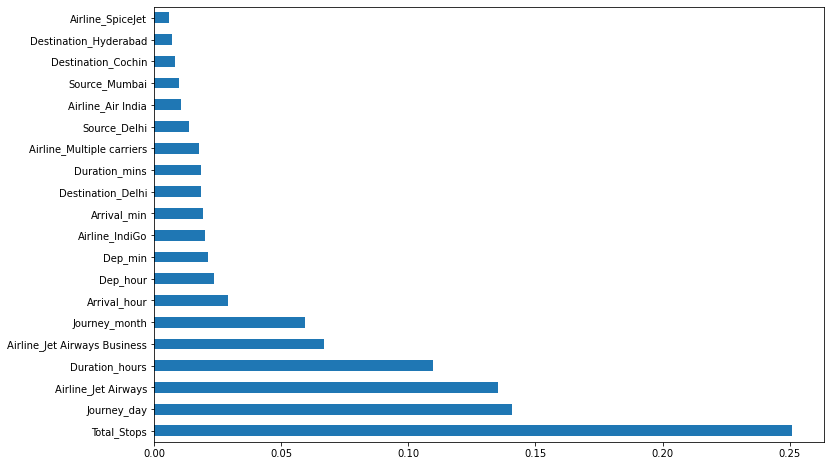

In [27]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

# **Models**

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

**1.Linear regressor**

In [54]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import metrics
 # create regressor object
regressor = LinearRegression()
# fit the regressor with x and y data
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
r2=metrics.r2_score(y_test,y_pred)
print("MAx R2",r2)

MAx R2 0.5999576289357331


**2.Random Forest Regressor**

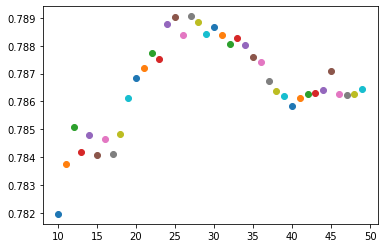

max R2 (0.7890591201169784, 27)


In [52]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import metrics
 # create regressor object
R2=[]
for i in range(10,50):
  regressor = RandomForestRegressor(n_estimators = i, random_state = 0)
  # fit the regressor with x and y data
  regressor.fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  r2=metrics.r2_score(y_test,y_pred)
  R2.append((r2,i))
  plt.scatter(i, r2)
plt.show()
print("max R2",max(R2))

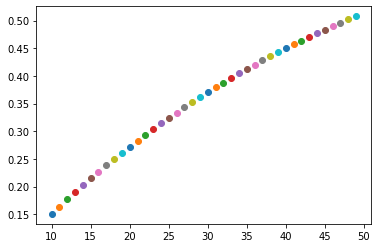

max R2 (0.50781512151826, 49)


In [58]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
 # create regressor object
R2=[]
for i in range(10,50):
  regressor = GradientBoostingRegressor(n_estimators=i, learning_rate=0.01, max_depth=20, random_state=0)
  # fit the regressor with x and y data
  regressor.fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  r2=metrics.r2_score(y_test,y_pred)
  R2.append((r2,i))
  plt.scatter(i, r2)
plt.show()
print("max R2",max(R2))

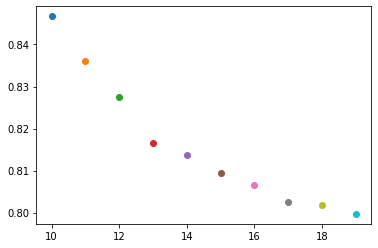

max R2 (0.8467202796693898, 10)


In [62]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from xgboost import XGBRegressor
 # create regressor object
R2=[]
for i in range(10,20):
  regressor = XGBRegressor(colsample_bytree=0.8,gamma=0.0,learning_rate=0.1,max_depth=i, min_child_weight=1,verbosity=0)
  # fit the regressor with x and y data
  regressor.fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  r2=metrics.r2_score(y_test,y_pred)
  R2.append((r2,i))
  plt.scatter(i, r2)
plt.show()
print("max R2",max(R2))

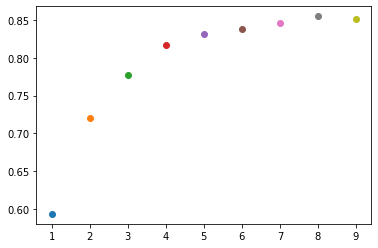

max R2 (0.8547184681388182, 8)


In [63]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from xgboost import XGBRegressor
 # create regressor object
R2=[]
for i in range(1,10):
  regressor = XGBRegressor(colsample_bytree=0.8,gamma=0.0,learning_rate=0.1,max_depth=i, min_child_weight=1,verbosity=0)
  # fit the regressor with x and y data
  regressor.fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  r2=metrics.r2_score(y_test,y_pred)
  R2.append((r2,i))
  plt.scatter(i, r2)
plt.show()
print("max R2",max(R2))

In [69]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics
from xgboost import XGBRegressor
 # create regressor object
R2=[]
parameters = {'n_estimators':[500], "max_features" : ["auto", "log2", "sqrt"],"bootstrap": [True, False]}
regressor = GridSearchCV(RandomForestRegressor(), parameters, n_jobs=-1)
# fit the regressor with x and y data
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
r2=metrics.r2_score(y_test,y_pred)
print("max R2",r2)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


max R2 0.7937216643709512


In [73]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics
from xgboost import XGBRegressor
 # create regressor object
R2=[]
parameters = {'n_estimators':[10], "max_features" : ["auto", "log2", "sqrt"],"bootstrap": [True, False]}
regressor = GridSearchCV(XGBRegressor(), parameters, n_jobs=-1)
# fit the regressor with x and y data
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
r2=metrics.r2_score(y_test,y_pred)
print("max R2",r2)

[22:44:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
max R2 0.006657158436126243
